**1. Define Problem Statement**

**Objective:**
The goal is to cluster learners from the Scaler database based on their job profiles, companies, and other features to identify groups with similar characteristics. This clustering will help in profiling the best companies and job positions, thereby assisting learners in making informed career decisions and optimizing the curriculum to better serve learner needs.

**Key Tasks:**

Data Understanding: Examine the dataset to understand the features and their relationships.
Data Cleaning: Handle missing values, outliers, and any data inconsistencies.
Exploratory Data Analysis (EDA): Gain insights into the distribution and patterns in the data.
Feature Engineering: Create meaningful features that enhance the clustering process.
Clustering Analysis: Apply clustering algorithms to identify groups of similar learners.
Cluster Profiling: Analyze and interpret the clusters to understand their characteristics and the types of job profiles and companies they represent.


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")

In [95]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/681/original/Scaler_Kmeans.csv")
df.drop("Unnamed: 0", inplace = True, axis = 1)

In [96]:
df.head()

,email_hash,company,normalized_company_name,orgyear,ctc,job_position,ctc_updated_year
0,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,Deloitte India,Deloitte,2016.0,1100000,Other,2020.0
1,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,Reliance Infocomm Limited,Reliance Jio Infocomm Limited,2018.0,449999,FullStack Engineer,2019.0
2,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,Synctactic AI,NaN,2015.0,2000000,Backend Engineer,2020.0
3,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,Tokopedia,Tokopedia,2017.0,700000,Backend Engineer,2019.0
4,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,RIFT Group,NaN,2017.0,1400000,FullStack Engineer,2019.0


In [97]:
df.shape

(206923, 7)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206923 entries, 0 to 206922
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   email_hash               206923 non-null  object 
 1   company                  204649 non-null  object 
 2   normalized_company_name  121425 non-null  object 
 3   orgyear                  206837 non-null  float64
 4   ctc                      206923 non-null  int64  
 5   job_position             153340 non-null  object 
 6   ctc_updated_year         206923 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 11.1+ MB


**Checking unique emails and frequency of occurrence of the same email hash in the data**

In [99]:
cat_columns = ['email_hash','company', "normalized_company_name", "job_position"]
for i in cat_columns:
  print(df[i].value_counts().head(5))
  print("---------------------")

email_hash
bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    10
6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c     9
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378     9
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee     9
b4d5afa09bec8689017d8b29701b80d664ca37b83cb883376b2e95191320da66     8
d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf93246d4192a89d8065     8
faf40195f8c58d5c7edc758cc725a762d51920da996410b80ac4a4d85c803da0     8
4818edfd67ed8563dde5d083306485d91d19f4f1c95d193a1700e79dd245b75c     8
d15041f58bb01c8ee29f72e33b136e26bc32f3169a40b53d75fe7ae9cbb9a551     8
c0eb129061675da412b0deb15871dd06ef0d7cd86eb5f7e8cc6a20b0d1938183     8
Name: count, dtype: int64
---------------------
company
Tata Consultancy Services    8457
Infosys                      5469
Amazon                       3501
Not Applicable Account       3414
Cognizant                    3266
Accenture                    2907
Wipro Limited      

There are multiple values for emails

In [100]:
df = df.groupby('email_hash').first().reset_index()

**Handling missing values using KNN imputer**

In [101]:
df.isnull().sum()

email_hash                     0
company                     1627
normalized_company_name    65424
orgyear                       78
ctc                            0
job_position               20225
ctc_updated_year               0
dtype: int64

**Removing special characters from the dataset by using Regex**

In [102]:
for i in cat_columns[1:]:
  print(i,":", df[i].unique()[:10])
  print(i,":", df[i].nunique())
  print("----------------------------")


company : ['Microsoft' 'TRGT Digital' 'Optum' 'Microsemi Corporation' 'Walmart Labs'
 'Tata Consultancy Services' 'Infracloud Technologies' 'Svp itqan oman'
 'ZS' 'Openvoy']
company : 40001
----------------------------
normalized_company_name : ['Microsoft' None 'Optum' 'Microsemi Corporation' 'Walmart'
 'Tata Consultancy Services' 'ZS Associates' 'Goldman Sachs' 'Verizon'
 'Hinduja Global Solutions']
normalized_company_name : 1154
----------------------------
job_position : ['Backend Engineer' 'FullStack Engineer' None 'Database Administrator'
 'Frontend Engineer' 'Other' 'SDET' 'Product Designer' 'Support Engineer'
 'Devops Engineer']
job_position : 820
----------------------------


In [103]:
text_cols = ['normalized_company_name', 'company', 'job_position']
for i in text_cols:
    df[i] = df[i].fillna('Not Available').apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x).title()))

**Checking for duplicates in the dataset and drop them**

In [104]:
df.duplicated().sum()

0

In [105]:
df.drop_duplicates(inplace = True)

In [106]:
df = df.groupby('email_hash').first().reset_index()

**Conversion of categorical attributes to 'category'**

In [107]:
df = df[(df['orgyear']>2000) & (df['orgyear'] < 2024)]
df["orgyear"] = pd.to_datetime(df['orgyear'].astype(float).astype(int), format='%Y')
df['ctc_updated_year'] = pd.to_datetime(df['ctc_updated_year'].astype(float).astype(int), format='%Y')

**Creaeting a new feature "years_of_experience" column by subtracting orgyear from current year**

In [108]:
df["years_of_experience"] = (df["ctc_updated_year"] - df["orgyear"]).dt.days/365
df = df[df['years_of_experience'] > 0]

Filtering data with experiance greater than 1 only

In [109]:
df.describe()

,orgyear,ctc,ctc_updated_year,years_of_experience
count,134135,1.341350e+05,134135,134135.000000
mean,2014-06-15 09:42:11.017258752,2.436882e+06,2019-07-26 02:26:52.304022016,5.114240
min,2001-01-01 00:00:00,2.000000e+00,2015-01-01 00:00:00,1.000000
25%,2012-01-01 00:00:00,5.700000e+05,2019-01-01 00:00:00,2.002740
50%,2015-01-01 00:00:00,1.000000e+06,2020-01-01 00:00:00,4.002740
75%,2017-01-01 00:00:00,1.700000e+06,2021-01-01 00:00:00,7.005479
max,2020-01-01 00:00:00,1.000150e+09,2021-01-01 00:00:00,20.013699
std,NaN,1.270011e+07,NaN,3.582207


In [110]:
df.describe(include = object)

,email_hash,company,normalized_company_name,job_position
count,134135,134135,134135,134135
unique,134135,33463,1135,700
top,00003288036a44374976948c327f246fdbdf0778546904...,Tata Consultancy Services,Not Available,Backend Engineer
freq,1,4381,56711,34474


**Frequency mean encoding**

In [111]:
frequecy_encoder = (df.groupby("job_position").size()) / len(df)*10000
df['job_position_encoded'] = df['job_position'].apply(lambda x : frequecy_encoder[x])
frequecy_encoder = (df.groupby("company").size()) / len(df)*10000
df['company_encoded'] = df['company'].apply(lambda x : frequecy_encoder[x])

**Plotting Categorical features**

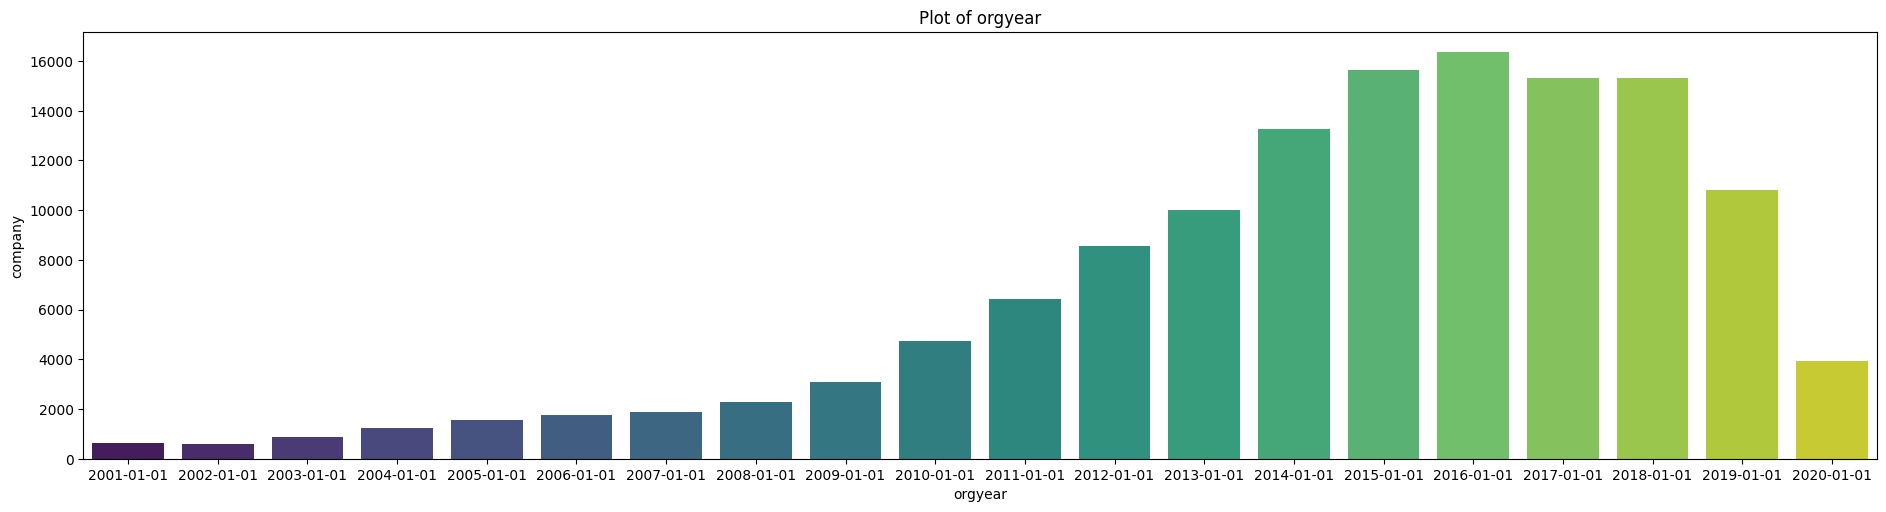

In [112]:
plt.figure(figsize = (19,5))
sns.barplot(x = "orgyear", y = "company", data = df.groupby("orgyear").count()['company'].reset_index(), palette= "viridis")
plt.tight_layout()
plt.title("Plot of orgyear")
plt.show()

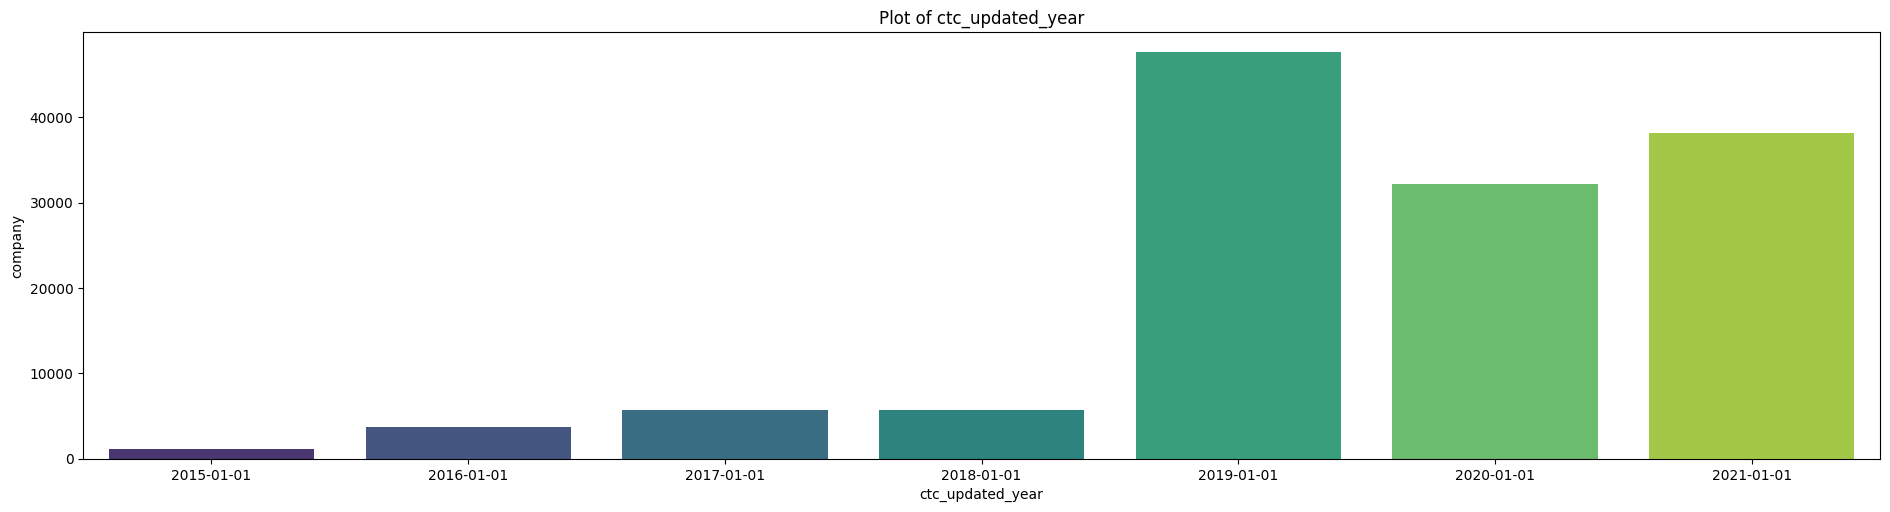

In [113]:
plt.figure(figsize = (19,5))
sns.barplot(x = "ctc_updated_year", y = "company", data = df.groupby("ctc_updated_year").count()['company'].reset_index(), palette= "viridis")
plt.tight_layout()
plt.title("Plot of ctc_updated_year")
plt.show()

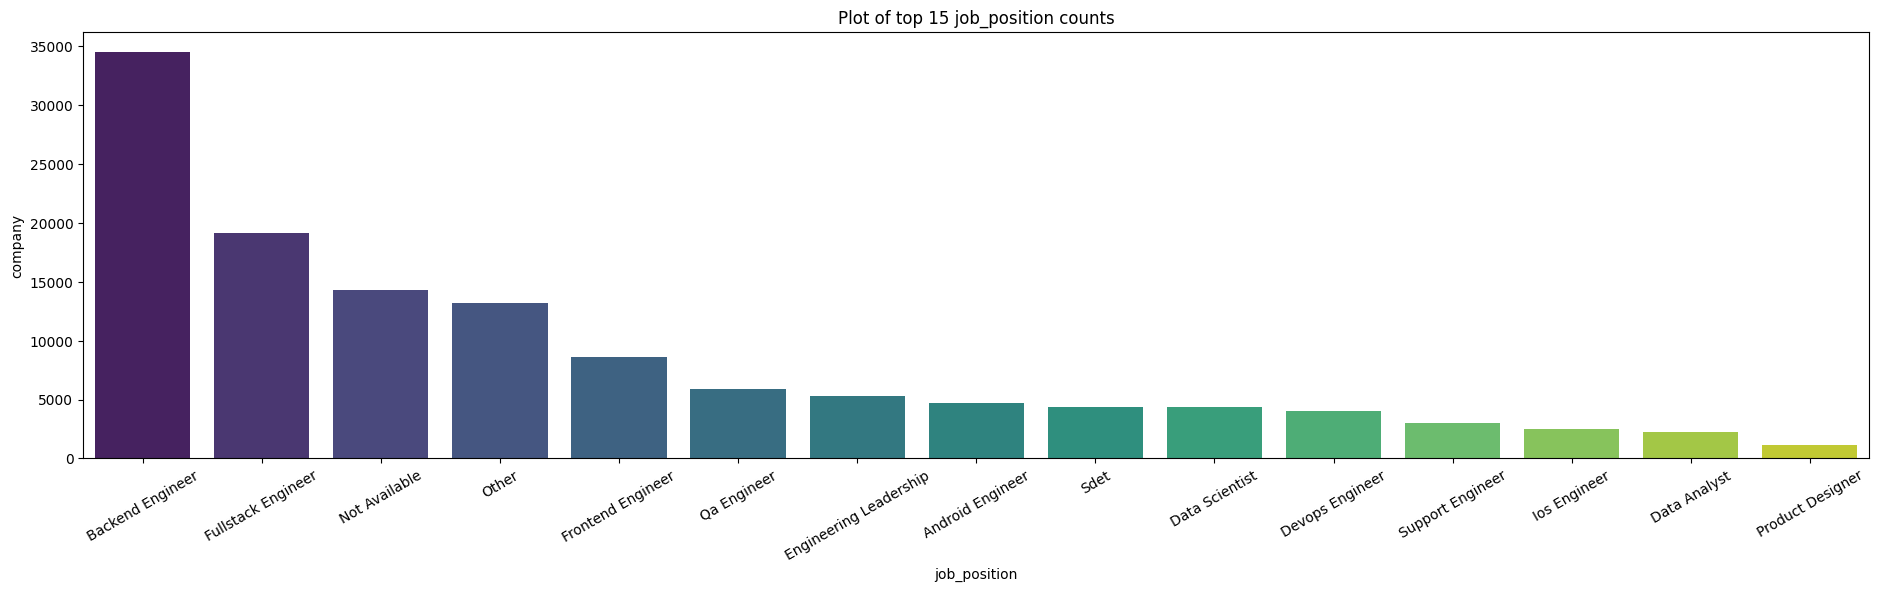

In [114]:
plt.figure(figsize = (19,5))
sns.barplot(x = "job_position", y = "company", data = df.groupby("job_position").count()['company'].reset_index().sort_values(by = "company", ascending = False).head(15), palette= "viridis")
plt.tight_layout()
plt.title("Plot of top 15 job_position counts")
plt.xticks(rotation = 30)
plt.show()

**Removing outliers to plot the distrubution of CTC with histogram**

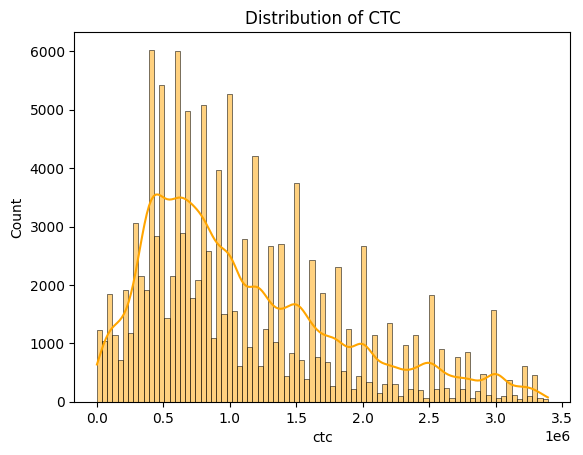

In [115]:
q1 = np.percentile(df['ctc'], 25)
q3 = np.percentile(df['ctc'], 75)
iqr = q3 - q1
lower = np.percentile(df['ctc'], 25) - (iqr * 1.5)
upper = np.percentile(df['ctc'], 75) + (iqr * 1.5)
df = df[(df['ctc'] >= lower) & (df['ctc'] <= upper)]

sns.histplot(x = "ctc", data = df, kde = True, color = "orange")
plt.title("Distribution of CTC")
plt.show()

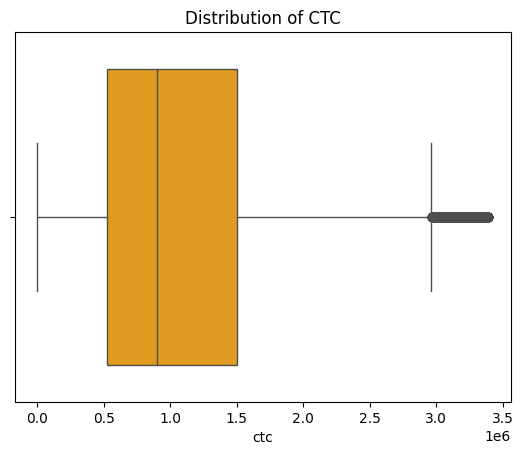

In [116]:
sns.boxplot(x = "ctc", data = df, color = "orange")
plt.title("Distribution of CTC")
plt.show()

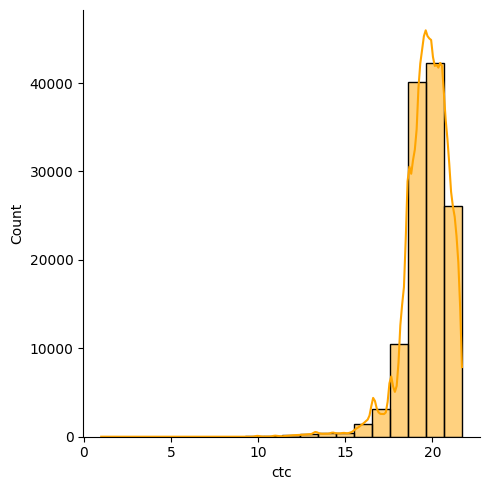

In [117]:
sns.displot(x = np.log2(df['ctc']), data = df, kde=True, bins=20, color = "orange")
plt.show()

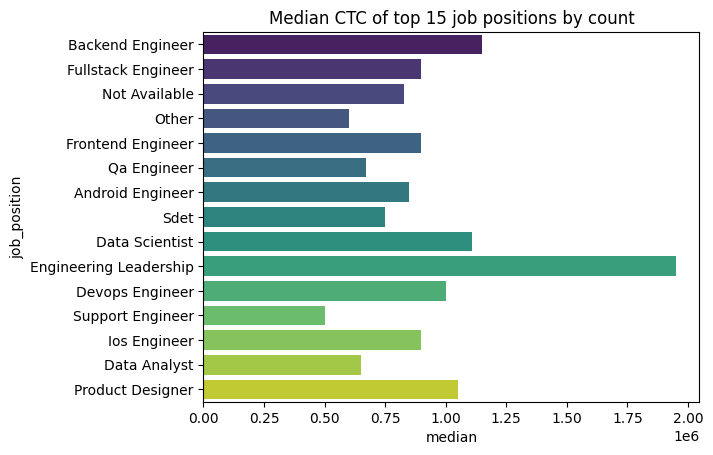

In [118]:
sns.barplot(y = "job_position", x = "median", data = df.groupby('job_position').agg(count=('job_position', 'size'), median=('ctc', 'median')).sort_values(by= ['count', 'median'], ascending=False).head(15),
                hue = "job_position", palette = "viridis")
plt.title("Median CTC of top 15 job positions by count")
plt.show()


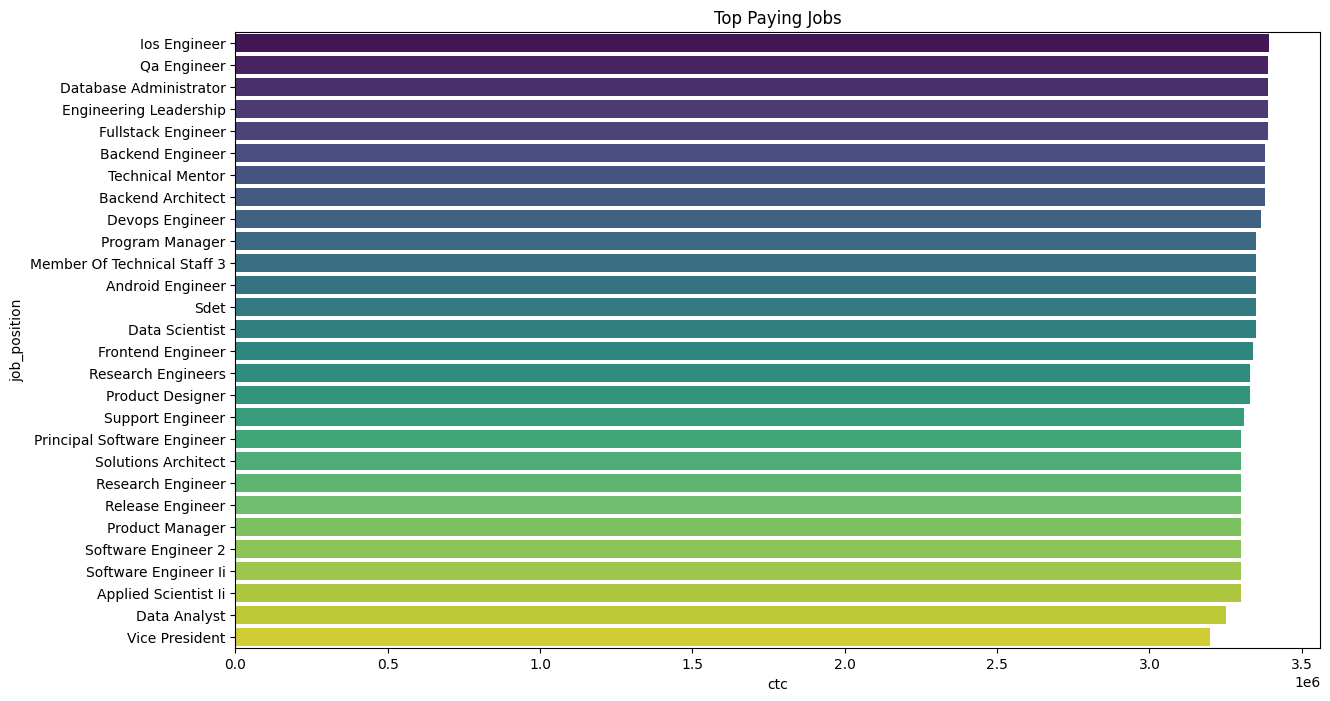

In [119]:
plt.figure(figsize = (14,8))
dftemp = df.groupby(['job_position']).max()['ctc'].reset_index().sort_values('ctc',ascending=False).head(30)
dftemp = dftemp[~dftemp["job_position"].isin(["Not Available", "Other"])]
sns.barplot(data= dftemp, x='ctc', y='job_position', palette = "viridis").set(title="Top Paying Jobs")
plt.show()

**Manual Clustering**

**Getting the 5 point summary of CTC (mean, median, max, min, count etc) on the basis of Job Position, Years of Experience**

feature 1: designation_flag_job_position

In [120]:
df_tmp1 = df.groupby(['company','job_position', 'years_of_experience']).agg({'ctc': ['mean', 'median', 'min', 'max', 'count']}).reset_index()
df_tmp1.columns = ['company', 'job_position', 'years_of_experience', 'ctc_mean', 'ctc_median', 'ctc_min', 'ctc_max', 'ctc_count']
df_tmp1.head()

,company,job_position,years_of_experience,ctc_mean,ctc_median,ctc_min,ctc_max,ctc_count
0,,Backend Engineer,2.000000,600000.0,600000.0,600000,600000,1
1,,Backend Engineer,8.005479,1600000.0,1600000.0,1600000,1600000,1
2,,Data Scientist,8.005479,910000.0,910000.0,910000,910000,1
3,,Fullstack Engineer,4.002740,700000.0,700000.0,700000,700000,1
4,,Not Available,1.000000,155000.0,155000.0,110000,200000,2


Merging the grouped 5 point summary of CTC  with original dataset and creating some flags showing learners with CTC greater than the Average of their Company’s department having same Years of Experience - creating flag designation with values [1, 2, 3]

In [121]:
data = df.merge(df_tmp1[['company','job_position', 'years_of_experience', 'ctc_mean']], on=['company','job_position', 'years_of_experience'], how='left')

conditions = [data["ctc"] > data["ctc_mean"], data["ctc"] == data["ctc_mean"], data["ctc"] < data["ctc_mean"]]
choices = [1, 2, 3]
data["designation_flag_job_position"] = np.select(conditions, choices)

data['diff_desig'] = data['ctc'] - data['ctc_mean']

data.drop("ctc_mean", inplace = True, axis = 1)

feature 2: class_flag_company

In [122]:
#  Company & Job Position level. Name that flag Class with values [1,2,3]
df_tmp2 = df.groupby(["company", "job_position"]).agg({'ctc': ['mean', 'median', 'min', 'max', 'count']}).reset_index()
df_tmp2.columns = ["company", "job_position", 'ctc_mean', 'ctc_median', 'ctc_min', 'ctc_max', 'ctc_count']

data = data.merge(df_tmp2[["company", "job_position", 'ctc_mean']], on=["company", "job_position"], how='left')

conditions = [data["ctc"] > data["ctc_mean"], data["ctc"] == data["ctc_mean"], data["ctc"] < data["ctc_mean"]]
choices = [1, 2, 3]
data["class_flag_company_job_position"] = np.select(conditions, choices)

data['diff_class'] = data['ctc'] - data['ctc_mean']

data.drop("ctc_mean", inplace = True, axis = 1)

feature 3: tier_flag_company

In [123]:
#  Company level. Name that flag Class with values [1,2,3]
df_tmp3 = df.groupby(["company"]).agg({'ctc': ['mean', 'median', 'min', 'max', 'count']}).reset_index()
df_tmp3.columns = ["company", 'ctc_mean', 'ctc_median', 'ctc_min', 'ctc_max', 'ctc_count']

data = data.merge(df_tmp3[["company", "ctc_mean"]], on=["company"], how='left')

conditions = [data["ctc"] > data["ctc_mean"], data["ctc"] == data["ctc_mean"], data["ctc"] < data["ctc_mean"]]
choices = [1, 2, 3]
data["tier_flag_company"] = np.select(conditions, choices)

data['diff_tier'] = data['ctc'] - data['ctc_mean']

data.drop("ctc_mean", inplace = True, axis = 1)
data.head()

,email_hash,company,normalized_company_name,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,job_position_encoded,company_encoded,designation_flag_job_position,diff_desig,class_flag_company_job_position,diff_class,tier_flag_company,diff_tier
0,0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...,Trgt Digital,Not Available,2013-01-01,250000,Backend Engineer,2020-01-01,7.002740,2570.097290,0.074552,2,0.0,2,0.000000,2,0.000000
1,000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...,Microsemi Corporation,Microsemi Corporation,2004-01-01,2000000,Fullstack Engineer,2021-01-01,17.013699,1429.157192,0.670966,2,0.0,1,932500.000000,1,383888.888889
2,0001b94dbb1e85477b07fb6558ead3456c3735893c81f4...,Tata Consultancy Services,Tata Consultancy Services,2018-01-01,380000,Database Administrator,2020-01-01,2.000000,35.113878,326.611250,2,0.0,3,-110514.647059,3,-199548.734092
3,00022dc29c7f77032275182b883d4f273ea1007aefc437...,Infracloud Technologies,Not Available,2016-01-01,750000,Frontend Engineer,2019-01-01,3.002740,643.605323,0.298207,2,0.0,3,-625000.000000,3,-357500.000000
4,00036c2c5212d88d07acdc5bda7eef5653f8b09bbe30b7...,Svp Itqan Oman,Not Available,2011-01-01,2300000,Other,2021-01-01,10.008219,983.561337,0.074552,2,0.0,2,0.000000,2,0.000000


Q. Top 10 employees (earning more than most of the employees in the company) - Tier 1

In [124]:
(data[data['tier_flag_company'] == 1]).sort_values(by = 'diff_tier', ascending = False).head(10)[['email_hash','ctc']]

,email_hash,ctc
95498,c41d6ade244ae41bba47acde9d69b67125409995efea4c...,3300000
56326,73cbc796a4302bd691bda6ad9da47ec92f366fb697869e...,3385000
51954,6aa8cfeb5b98da66158e0af4ca8869362174abdba84a02...,3200000
14091,1c6cd4e20db2d0967b315bb19cd991352394bdfc28ee56...,3300000
71152,920942db36449787d08cf3dcf4278b39a68c047df203f4...,3300000
83079,aa8521c142167f599ad8c7527315ed1798ac911a22f6ae...,3200000
68205,8c25c57ed131b6c49c0d3209f549083788007b9d450fed...,3200000
118313,f297f8f6b3968fd37bd252224196111793eba0bc56cb46...,3000000
87188,b2d8486916d345c0edd7b73dae847f22946f82bf03a1a7...,3300000
91409,bb9600be094b76d892d05b6bbee8c49695fa8e24957397...,3300000


Q. Bottom 10 employees (earning less than most of the employees in the company)- Tier 3

In [125]:
(data[data['tier_flag_company'] == 3]).sort_values(by = 'diff_tier', ascending = True).tail(10)[['email_hash','ctc']]

,email_hash,ctc
123001,fc180f7191a79cf840450ce94f99e35077094519c8eed1...,999999
56498,74220558441a8c6fe1f52305ae21eeb468c6dcb59767cf...,1000000
77624,9f58e477476d5c7a2a693782bf9f53a726f37e7dd9c3cb...,1000000
26367,35d0fd8256cae65f72c5db5cff1dbd63c30e5942dab911...,1000000
29246,3bbd15958f36cb4accacc309b3d8bbbd34e8f683323eba...,1550000
4900,09ab3499c5ba485153163ec5dc33a8e7aa2a22fc1ae293...,1550000
55891,72db4d5b00623747cdad8738ebb6c94552d02d4f39ac4d...,800000
117965,f1e8238481257547df3a4c0f92299a4150015f9bcf2021...,890000
81940,a8443c52df06957595d1d64d1721313de489e25ac0c6f6...,819999
107118,dbb893f6ce303500c75659397c2eaadf5f531e754bdde6...,819999


**Q. Top 10 employees in each company - X department - having 5/6/7 years of experience earning more than their peers - Tier X**

In [126]:
data[(data['years_of_experience'] >= 5) & (data['years_of_experience'] <= 7) & (data['tier_flag_company'] ==  1)].sort_values(by = 'diff_tier', ascending = False).head(10)[['email_hash','ctc']]

,email_hash,ctc
83079,aa8521c142167f599ad8c7527315ed1798ac911a22f6ae...,3200000
91409,bb9600be094b76d892d05b6bbee8c49695fa8e24957397...,3300000
121760,f982608395d7209dff7d8f19af2bdb0e1256240107bd46...,3220000
96271,c5b16ad982ca39de374d8f34d3cea8373fae83bebe169d...,3080000
54138,6f33b59bcd95eb41461be6532a1f11239c75b9da717727...,3150000
35109,4815e84eec35712692738728d4e467348117e404f0d89f...,3200000
40048,525bb6b98a6fb8aa1060a2dbcf39405b1873aa58d15cef...,3000000
23775,308cf4f716697c7c5a5534958726f61cba1bede17ded86...,3000000
108356,de541fe23524fad6bf276355420a2cb05c3616f82d2c01...,2800000
24482,3209548294ccba92dd9c7ba4a859404fb5ca72e516544f...,3000000


Q. Top 10 companies (based on their CTC)

In [127]:
data.groupby("company").agg({"ctc": "mean"}).sort_values(by = "ctc", ascending = False).head(10)

,ctc
company,
Target Corporation India Bangalore,3390000.0
Akamai Technology,3390000.0
E Clinicalworks India Pvt Ltd,3380000.0
Technip,3380000.0
Copious Software South Africa,3360000.0
Ubs Investment Bank,3360000.0
Lupin,3350000.0
Citi Corp Services India Ltd,3350000.0
Gainspan,3350000.0


Top 2 positions in every company (based on their CTC)

In [128]:
# mean ctc for each company for each position
data_temp = data.groupby(["company", "job_position"]).agg({"ctc": "mean"}).sort_values(by = "ctc", ascending = False).reset_index()

# creating ranks for position in company
data_temp['rank'] = data_temp.groupby(["company"])['ctc'].rank(method='first', ascending=False)

# selecting top 2 positions for each company
data_temp = data_temp[data_temp['rank'] <= 2]


data_temp.sort_values(by = ['company','rank'])


,company,job_position,ctc,rank
19072,,Backend Engineer,1100000.0,1.0
24325,,Data Scientist,910000.0,2.0
38442,Syneos Health,Not Available,550000.0,1.0
34646,247 Customer Pvt Ltd,Devops Engineer,640000.0,1.0
10189,3Dwalk A StartUp,Not Available,1600000.0,1.0
...,...,...,...,...
5446,Zyoin,Not Available,2000000.0,1.0
41545,Zypp Electric,Data Scientist,470000.0,1.0
47906,Zyptv,Other,240000.0,1.0
6235,Zyudly Labs,Data Scientist,1950000.0,1.0


**Data processing for Unsupervised clustering - Label encoding/ One- hot encoding, Standardization of data**

In [129]:
data_ = data
data_.drop(['normalized_company_name','job_position','email_hash','company', "orgyear", "ctc_updated_year"], inplace = True, axis = 1)
data = data_.copy()

Removing 'normalized_company_name','job_position','email_hash','company' as they are strings. and also removing datetime features.

In [130]:
data.isna().sum()

ctc                                0
years_of_experience                0
job_position_encoded               0
company_encoded                    0
designation_flag_job_position      0
diff_desig                         0
class_flag_company_job_position    0
diff_class                         0
tier_flag_company                  0
diff_tier                          0
dtype: int64

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


Using PCA to convert data from multi dimention to 2 dimention

In [132]:
from sklearn.decomposition import PCA

pca = PCA(2)

components_pca = pca.fit_transform(data_scaled)

Defining function to visualize clusters

In [133]:
def viz_clusters(clusters):
    plt.scatter(clusters['X1'], clusters['X2'], c=clusters['label'], s = 40)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Visualizing Clusters')

**Checking clustering tendency, Elbow method & K- means clustering**

In [134]:
from sklearn.cluster import KMeans


In [135]:
kmeans_iter1 = KMeans(n_clusters=3, init="random", n_init=1,
                     algorithm="full", random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", random_state=0)
kmeans_iter3 = KMeans(n_clusters=8, init="random", n_init=1,
                     algorithm="full", random_state=0)
kmeans_iter1.fit(data_scaled)
kmeans_iter2.fit(data_scaled)
kmeans_iter3.fit(data_scaled)

KMeans(algorithm='full', init='random', n_init=1, random_state=0)

In [136]:
clusters_1 = pd.DataFrame(components_pca, columns=['X1', 'X2'])
clusters_1['label'] = kmeans_iter1.labels_


clusters_2 = pd.DataFrame(components_pca, columns=['X1', 'X2'])
clusters_2['label'] = kmeans_iter2.labels_


clusters_3 = pd.DataFrame(components_pca, columns=['X1', 'X2'])
clusters_3['label'] = kmeans_iter3.labels_


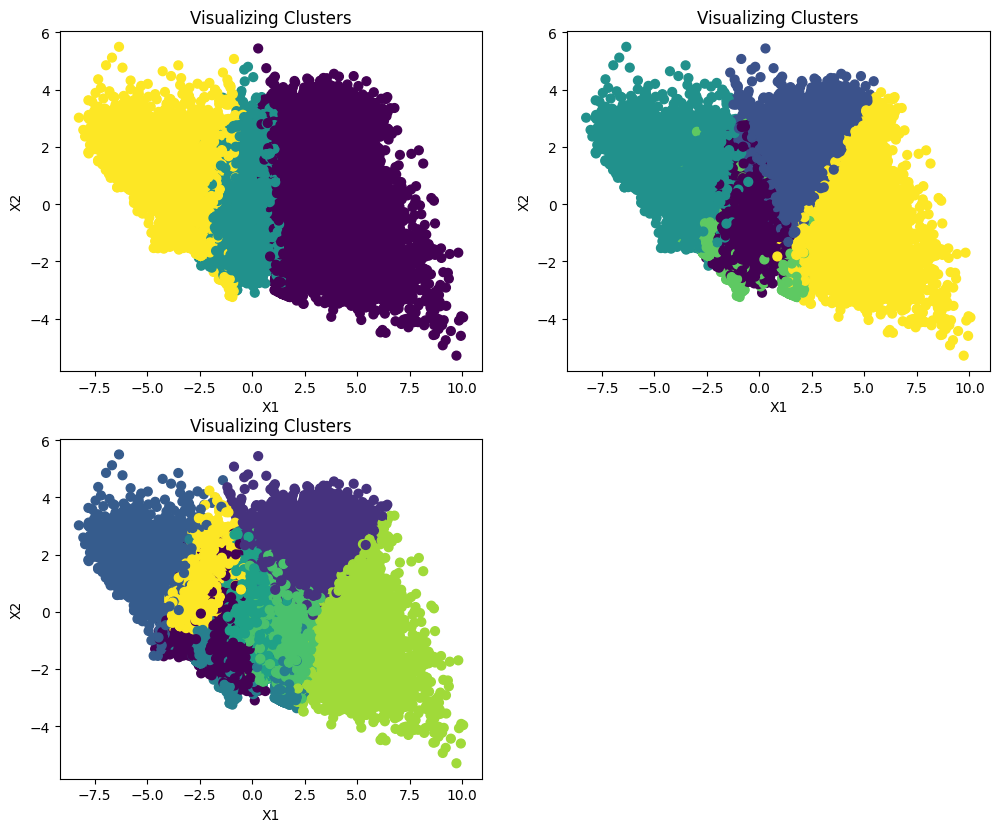

In [137]:
plt.figure(figsize=(12,15))

plt.subplot(321)
viz_clusters(clusters_1)

plt.subplot(322)
viz_clusters(clusters_2)

plt.subplot(323)
viz_clusters(clusters_3)

when number of cluster = 3 data is quite separable

In [138]:
print(kmeans_iter1.inertia_)
print(kmeans_iter2.inertia_)
print(kmeans_iter3.inertia_)

753944.134701807
625908.1880659352
514463.9756710677


In [139]:
# Inertia = Within Cluster Sum of Squares
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data_scaled)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

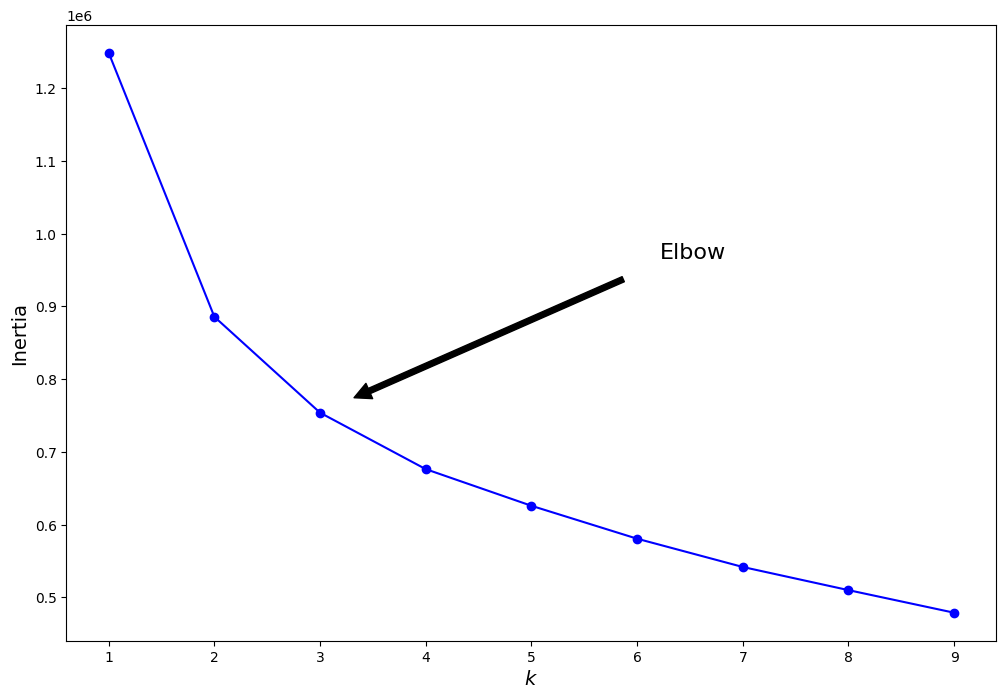

In [140]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

by elbow menthod 3 clusters whould be good with our dataset


**Silhouette score**

In [141]:
from sklearn.metrics import silhouette_score

k = 4
kmeans = KMeans(n_clusters=k,random_state = 42)
kmeans.fit(data_scaled)


KMeans(n_clusters=4, random_state=42)

In [142]:
## silhouette score for 4 clusters
# silhouette_score(data_scaled, kmeans.labels_)
silhouette_score = 0.21622030322410438

In [143]:
## plot for different values of K
# silhouette_scores = [silhouette_score(data_scaled, model.labels_)
#                      for model in kmeans_per_k[1:]]

In [144]:
silhouette_scores = [0.2855082052680263, 0.2215062209570358, 0.21622030322410438, 0.21825118484625108, 0.18597083639153061, 0.2006639235394882, 0.19677926992434772, 0.20372746678783113]


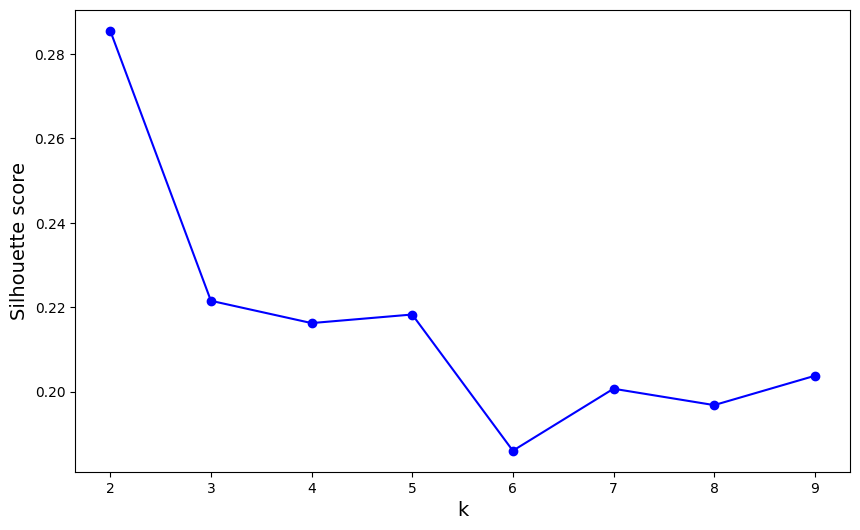

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

Lebeling data with number of cluster = 3

In [146]:
k = 3
kmeans = KMeans(n_clusters=k,random_state = 42)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=42)

In [147]:
data_scaled["labels_KMM"] = kmeans.labels_

In [148]:
data_scaled.head()

,ctc,years_of_experience,job_position_encoded,company_encoded,designation_flag_job_position,diff_desig,class_flag_company_job_position,diff_class,tier_flag_company,diff_tier,labels_KMM
0,-1.140943,0.606573,1.526477,-0.490979,-0.062052,0.0,-0.097817,9.997188e-19,-0.128292,-4.124374e-18,0
1,1.201059,3.531496,0.248628,-0.482877,-0.062052,0.0,-1.332226,2.118538e+00,-1.254874,7.171885e-01,1
2,-0.966965,-0.855087,-1.312696,3.945144,-0.062052,0.0,1.136593,-2.510771e-01,0.998289,-3.728007e-01,2
3,-0.471799,-0.562115,-0.631188,-0.487941,-0.062052,0.0,1.136593,-1.419931e+00,0.998289,-6.678883e-01,0
4,1.602545,1.484690,-0.250438,-0.490979,-0.062052,0.0,-0.097817,9.997188e-19,-0.128292,-4.124374e-18,0


In [149]:
data_scaled["labels_KMM"].value_counts()

labels_KMM
0    61295
1    35047
2    28529
Name: count, dtype: int64

**As hierarchical clustering is computationally expensive, performing the clustering on random 2000 rows only**

In [150]:
sampled_data = data_scaled.drop("labels_KMM", axis = 1).sample(n=2000, random_state=42)


In [151]:
import scipy.cluster.hierarchy as sch

In [152]:
Z = sch.linkage(sampled_data, method = "ward")

In [153]:
Z.shape

(1999, 4)

In [154]:
Z

array([[6.30000000e+01, 9.72000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.70000000e+01, 1.72900000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.37000000e+02, 7.83000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [3.98900000e+03, 3.99300000e+03, 4.87538149e+01, 6.00000000e+02],
       [3.99400000e+03, 3.99500000e+03, 6.44387521e+01, 1.40000000e+03],
       [3.99600000e+03, 3.99700000e+03, 1.04014336e+02, 2.00000000e+03]])

- The first 2 columns are cluster name.
- 3rd column is the distance between them
- 4th column is  no of data points inside that cluster


Text(0, 0.5, 'distance')

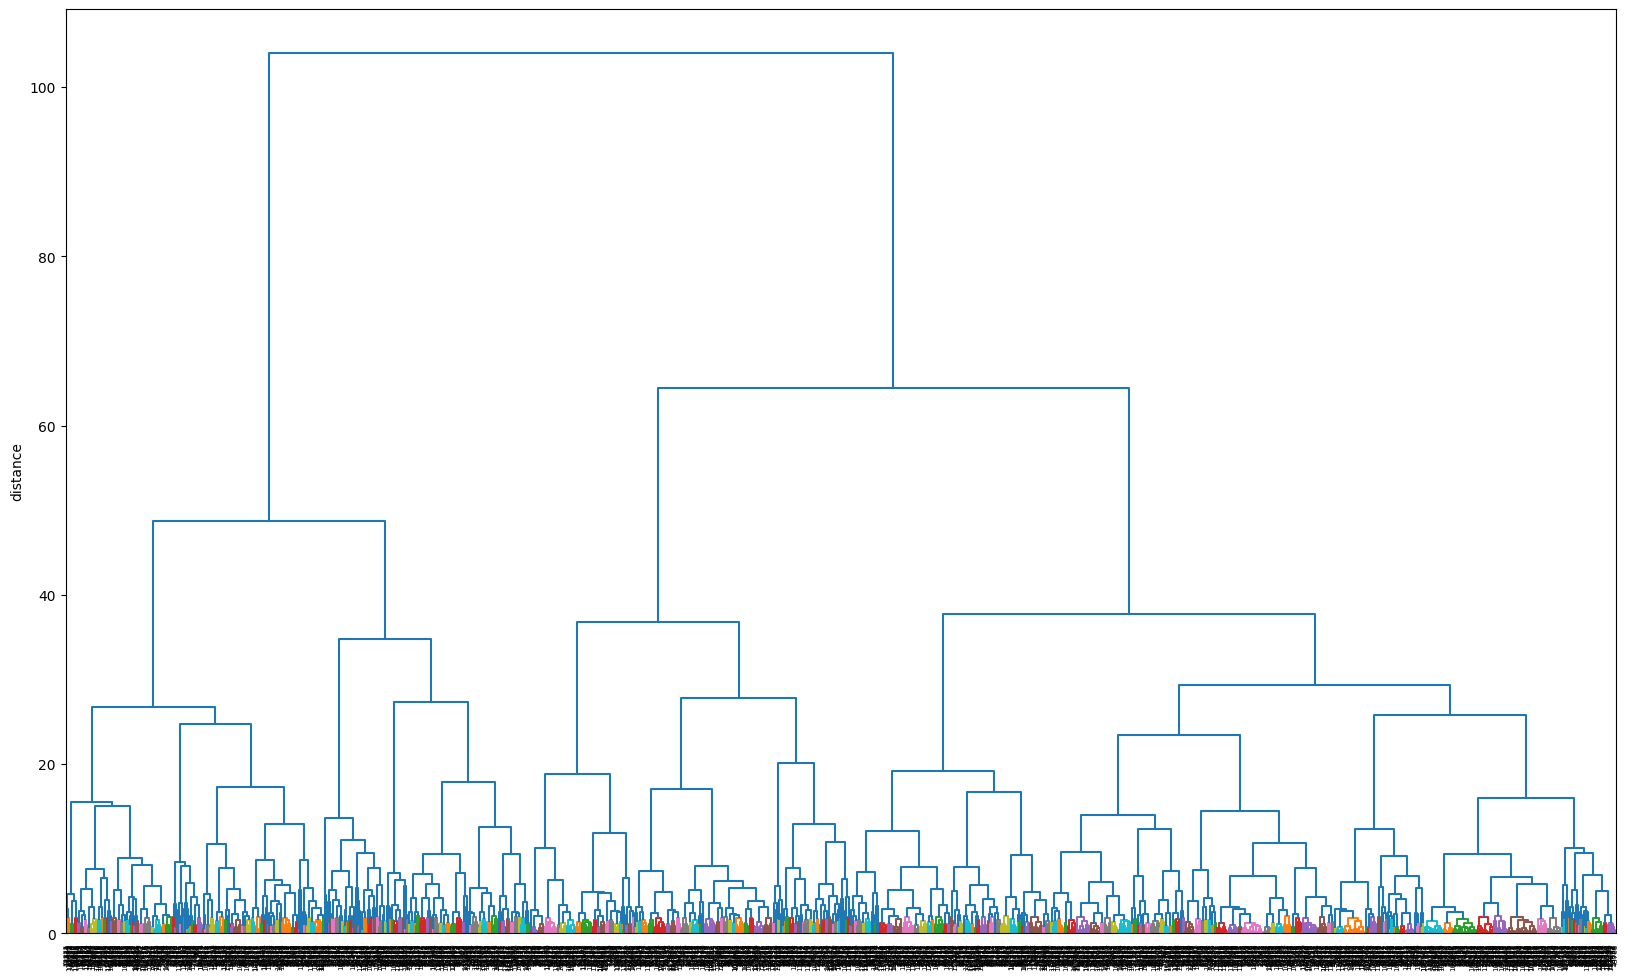

In [155]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sampled_data.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

looking at dendogram 3 number of clusters is better choice for our dataset

Text(0, 0.5, 'distance')

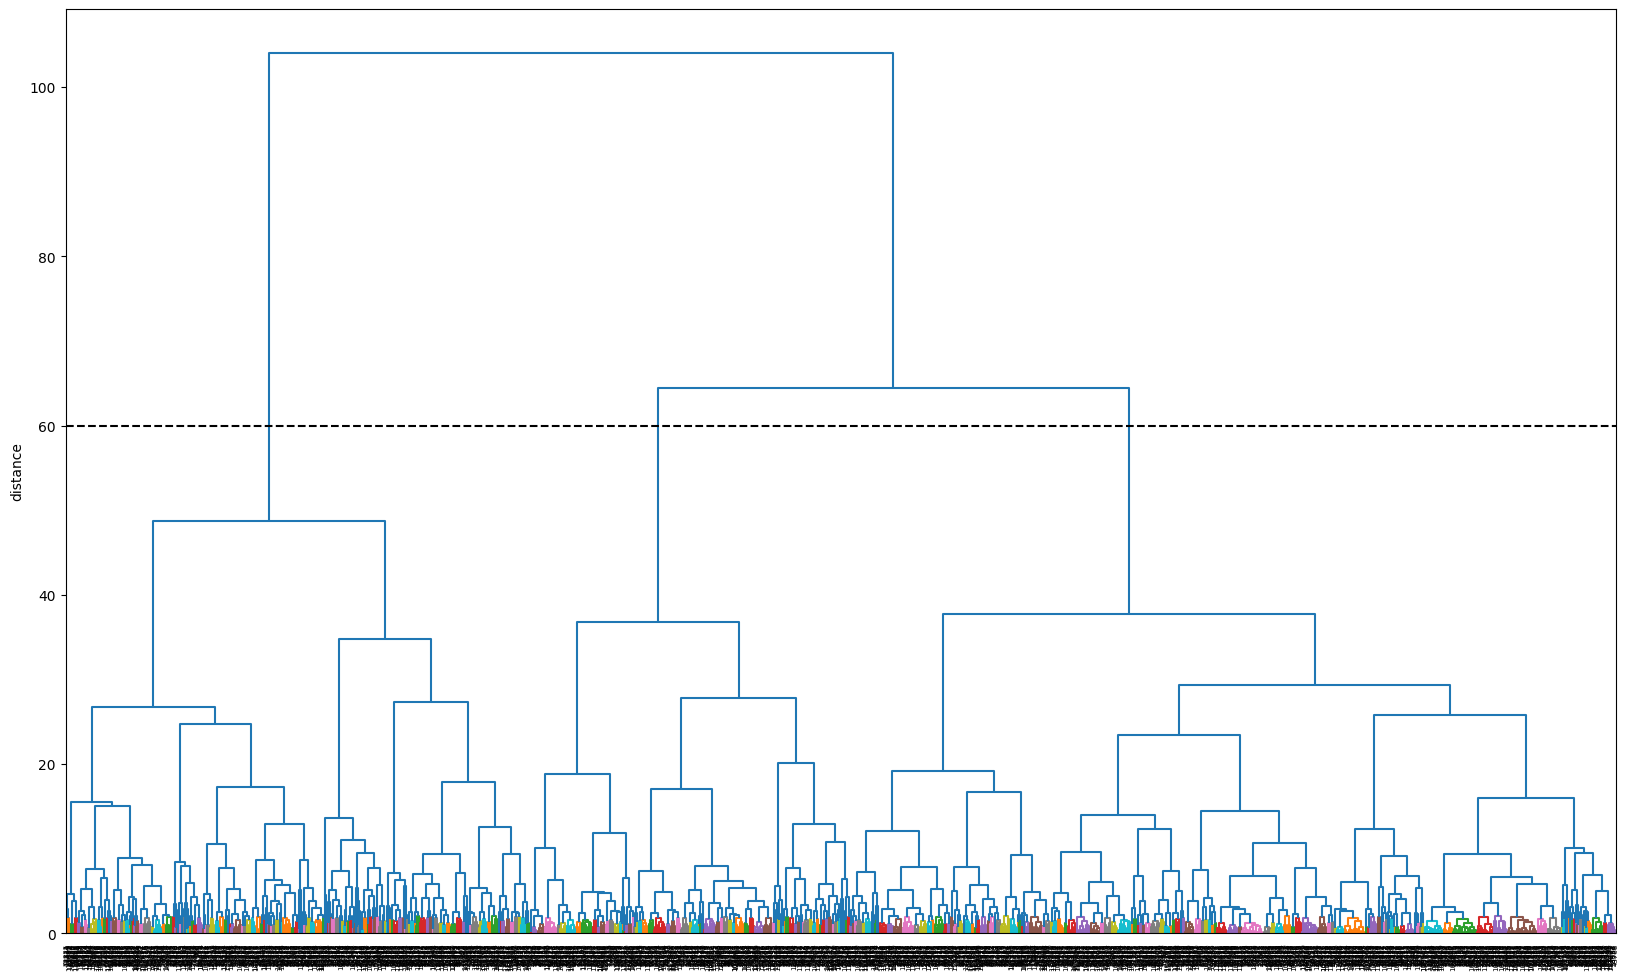

In [156]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sampled_data.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
plt.axhline(y=60, color='k', linestyle='--')
ax.set_ylabel('distance')

Performing Agglomerative Clustering with 3 clusters

In [157]:
# import hierarchical clustering libraries
from sklearn.cluster import AgglomerativeClustering

# create clusters
model = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
y_pred = model.fit_predict(sampled_data)

In [158]:
sampled_data['Model_labels'] = y_pred

In [159]:
from sklearn.metrics import silhouette_score

# Hierarchical clustering

labels = model.fit_predict(sampled_data)
silhouette_ = silhouette_score(sampled_data, labels)

silhouette_

0.2440508530917221

In [160]:
from sklearn.manifold import TSNE

# t-SNE dimensionality reduction
model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = model.fit_transform(sampled_data)

# Create DataFrame for plotting
tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, sampled_data['Model_labels'])).T, columns=("Dim_1", "Dim_2", "label"))

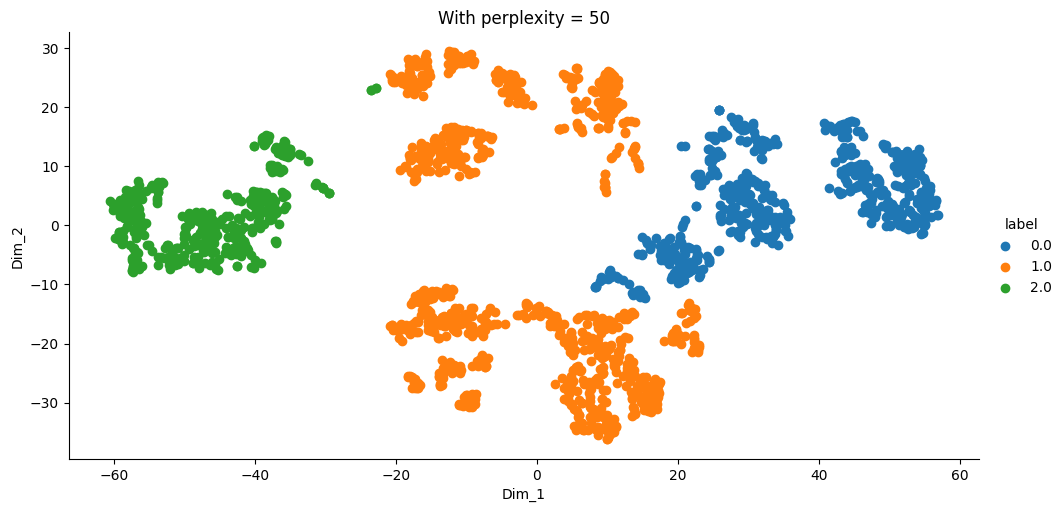

In [161]:
# Plot using Seaborn
sns.FacetGrid(tsne_df, hue="label", height=5 ,aspect= 2).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

**Insights**

The top-paying job titles include 'Engineering Leadership', 'Backend Engineer', 'Product Manager', 'Program Manager', 'SDET', 'QA Engineer', 'Data Scientist', 'Android Engineer', and 'FullStack Engineer'. Leading companies offering the highest salaries are 'Cisco', 'Intel Technology India Pvt Ltd', 'Amazon', 'Walmart Labs', 'Symantec', 'Schneider Electric India', 'Morgan Stanley', 'Ericsson RD Bangalore', and 'Samsung Electronics'.

Among these top-paying companies, salaries have been declining in recent years for Goldman Sachs, Tata Consultancy Services, Samsung Electronics, VMware, Dell, DBS Bank, HSBC Software Development India, and GE. Conversely, the average salary for companies like Amazon, Microsoft, and Huawei Technologies has been increasing annually. Overall, the average CTC appears to be decreasing over time.

**Recommendations**

Freshers aspiring to work in technical roles should target positions such as Backend Engineer, SDET, QA Engineer, Data Scientist, Android Engineer, and Full Stack Engineer for lucrative salaries as they gain experience.

For the highest CTC, freshers should aim to join companies like 'Cisco', 'Intel Technology India Pvt Ltd', 'Amazon', 'Walmart Labs', 'Symantec', 'Schneider Electric India', 'Morgan Stanley', 'Ericsson RD Bangalore', and 'Samsung Electronics'.







In [162]:
!sudo apt-get install texlive-xetex texlive-fonts-recommendedtexlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package texlive-fonts-recommendedtexlive-plain-generic
